In [37]:
import numpy as np
import cvxpy as cp
from itertools import combinations
import matplotlib.pyplot as plt

In [31]:
n = 20
d = 4
cln = 3
lam = 4
# pts = gen_polygon(n, n / (2 * np.pi))
# pts = random_on_sphere(n, d)
pts = cluster_mixture(n, cln)
alpha, beta, delta = primal_dual(n, pts, lam, use_beta=True)

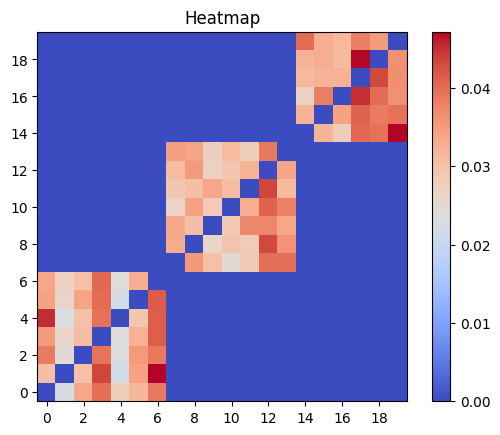

In [42]:
# beta heatmap
make_heatmap(n, beta)

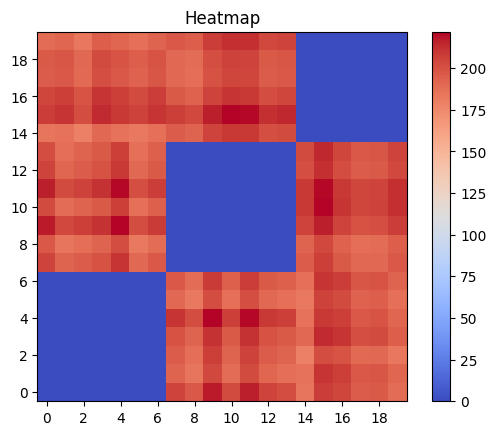

In [43]:
# slack heatmap
slack = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        if j == i:
            continue
        lhs = alpha[i] + alpha[j] - beta[i][j] - beta[j][i] + sum(delta[k][max(i, j)][min(i, j)] for k in range(n))
        lhs -= sum(delta[i][j][k] for k in range(n)) + sum(delta[i][k][j] for k in range(n))
        lhs -= sum(delta[j][i][k] for k in range(n)) + sum(delta[j][k][i] for k in range(n))
        slack[i, j] = np.linalg.norm(pts[i] - pts[j]) ** 2 - lhs
        
make_heatmap(n, slack)

In [29]:
## Our main solver -- TODO: optimize alphas one after another.

def primal_dual(n, pts, lam, use_beta=False):
    threshold = 0.00001
    frozen = {}
    beta = delta = None
    
    while len(frozen) < n:
        if use_beta:
            alpha, beta, delta = grow_alpha(n, pts, lam, frozen, True)
            for i in range(n):
                if abs(alpha + sum(beta[i]) + sum(sum(delta[i])) - lam) < threshold and i not in frozen:
                    frozen[i] = alpha            
        else:
            raise Exception("not implemented")

    return frozen, beta, delta
                
    


def grow_alpha(n, pts, lam, frozen, use_beta=False):
    a = cp.Variable()
    if use_beta:
        b = cp.Variable((n, n))
    d = [cp.Variable((n, n)) for _ in range(n)]
    constraints = []    
    if use_beta:
        constraints += [b >= 0]
        constraints += [cp.diag(b) == 0]  # beta_{ii} = 0
    constraints += [d[i] >= 0 for i in range(n)]
    for i in range(n):
        # set diagonal, i-th row, i-th col to be 0. these correspond
        # to delta_{ijj}, delta_{iij}, delta_{iji}.
        constraints += [cp.diag(d[i]) == 0]
        constraints += [d[i][i] == 0]
        constraints += [d[i][:, i] == 0]
    for i in range(n):
        alpha = frozen[i] if i in frozen else a
        if use_beta:
            constraints.append(alpha + cp.sum(b[i]) + cp.sum(d[i]) <= lam)
        else:
            constraints.append(alpha + cp.sum(d[i]) <= lam)
    for i, j, k in combinations(range(n), 3):
        # define delta_{ijk} for middle vertex i and j < k
        constraints.append(d[i][k][j] == 0)
        constraints.append(d[j][k][i] == 0)
        constraints.append(d[k][j][i] == 0)
    for i in range(n-1):
        for j in range(i+1, n):
            alpha_i = frozen[i] if i in frozen else a
            alpha_j = frozen[j] if j in frozen else a
            c = alpha_i + alpha_j 
            if use_beta:
                c += - b[i][j] - b[j][i]
            for k in range(n):
                if k != i and k != j:
                    c += d[k][i][j]
                    f, g = sorted([i, k])
                    c -= d[j][f][g]
                    f, g = sorted([j, k])
                    c -= d[i][f][g]
            constraints.append(c <= np.linalg.norm(pts[i] - pts[j]) ** 2)

    prob = cp.Problem(cp.Maximize(a), constraints)
    prob.solve()
    
    if use_beta:
        return a.value, b.value, [d[i].value for i in range(n)]
    else:
        return a.value, [d[i].value for i in range(n)]
        
# takes in an n x n numpy array and creates a heatmap
def make_heatmap(n, arr, cmin=None, cmax=None, title='Heatmap'):
    plt.imshow(arr, cmap='coolwarm', interpolation='nearest', vmin=cmin, vmax=cmax)
    plt.colorbar()
    plt.title(title)
    plt.xticks(np.arange(0, n, 2))
    plt.yticks(np.arange(0, n, 2))
    plt.gca().invert_yaxis()
    plt.show()

#### ------------- Functions to generate points

# function to generate an n-gon
def gen_polygon(n, r=1, cx=0, cy=0):
    t = 2 * np.pi / n
    pts = [[r*np.cos(t*i), r*np.sin(t*i)] for i in range(n)]
    return [cx, cy] + np.array(pts)
    
def random_on_sphere(n, d):
    pts = []
    for _ in range(n):
        x = np.random.rand(d) 
        x /= np.linalg.norm(x)
        pts.append(x)
    return np.array(pts)

def cluster_mixture(n, cln):
    d = cln + 3
    clus_cent = np.zeros([cln, d])
    for i in range(cln):
        clus_cent[i][i] = 10
    pts = []
    for i in range(n):
        x = np.random.rand(d) 
        x /= np.linalg.norm(x)
        index = i / (int(n) / int(cln))
        pts.append(x + clus_cent[int(index)])
    return np.array(pts)